In [647]:
import numpy as np
import jax.numpy as jnp
import jax
import scipy.linalg
import matplotlib.pyplot as plt

import pyequion2

In [648]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [649]:
class TransportBuilder(object):
    def __init__(self, eqsys, TK, shear_velocity, kinematic_viscosity, cbulk, phases):
        self.eqsys = eqsys
        self.TK = TK
        self.shear_velocity = shear_velocity
        self.kinematic_viscosity = kinematic_viscosity
        self.cbulk = cbulk
        self.phases = phases
        
    def set_species(self):
        self.species = eqsys.solutes
        self.species_ind = jnp.array([eqsys.species.index(spec) for spec in self.species])
        self.solid_ind = jnp.array([eqsys.solid_phase_names.index(phase) for phase in self.phases])
        self.reduced_formula_matrix = self.eqsys.formula_matrix[2:, self.species_ind]
        self.reduced_stoich_matrix = self.eqsys.stoich_matrix[:, 1:]
        self.reduced_reaction_vector = \
            eqsys.solid_stoich_matrix[self.solid_ind, :][:, self.species_ind]
        self.closure_matrix = jnp.array(
            scipy.linalg.null_space(
                (self.reduced_formula_matrix@(self.reduced_reaction_vector.T)).T
            ).T
        )
        self.nspecies = len(self.species)
        self.logk_solid = eqsys.get_solid_log_equilibrium_constants(self.TK)[self.solid_ind]
        self.logk_solutes = self.eqsys.get_log_equilibrium_constants(self.TK)
        self.reduce_activity_function()
        self.reduced_diffusion_coefficients = pyequion2.equilibrium_backend.diffusion_coefficients.get_diffusion_coefficients(
                                        self.species, self.TK)
        self.reduced_diffusion_coefficients = jnp.array(self.reduced_diffusion_coefficients)/self.kinematic_viscosity
        
    def reduce_activity_function(self):
        self._actfunc = pyequion2.equilibrium_backend.ACTIVITY_MODEL_MAP[eqsys.activity_model](
                            self.species, backend="jax")

    def make_grid(self, ngrid, ymax):
        self.ngrid = ngrid
        self.npoints = ngrid + 1
        self.ymax = ymax
        self.ygrid, self.ystep = jnp.linspace(0, self.ymax, self.npoints, retstep=True)
        
    def wall_diffusion_plus(self, yplus):
        return 9.5*1e-4*yplus**3
    
    def wall_diffusion_plus_deriv(self, yplus):
        return 3*9.5*1e-4*yplus**2
    
    def bulk_boundary_condition(self, logc, loga):
        cbulk = self.cbulk[..., None]
        return self.reduced_formula_matrix@(jnp.exp(logc[:, -1][..., None])) - cbulk
        
    def equilibrium_wall_boundary_condition(self, logc, loga):
        logKsolid = self.logk_solid[..., None]
        c = jnp.exp(logc)
        dc = (c[:, 1] - c[:, 0])/(self.ystep)
        res1 = self.reduced_reaction_vector@loga[:, 0] - logKsolid
        res2 = self.closure_matrix@\
                self.reduced_formula_matrix@\
                (self.reduced_diffusion_coefficients*dc)[..., None]
        res = jnp.vstack([res1, res2])
        return res
        
    def transport_middle_residual(self, logc, loga):
        #logc : (nsolutes, ngrid)
        #loga : (nsolutes, ngrid)
        c = jnp.exp(logc)
        ymiddle = self.ygrid[1:-1]
        cm = c[:, 1:-1]
        dc1 = (c[:, 2:] - c[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        dloga1 = (loga[:, 2:] - loga[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        dc2 = (c[:, 2:] - 2*c[:, 1:-1] + c[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2)
        dloga2 = (loga[:, 2:] - 2*loga[:, 1:-1] + loga[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2)
        molecular_diffusions = self.reduced_diffusion_coefficients[..., None] #(nsolutes, 1)
        turbulent_diffusions = self.wall_diffusion_plus(ymiddle)
        turbulent_diffusions_deriv = self.wall_diffusion_plus_deriv(ymiddle)
        term1 = molecular_diffusions*(dc1*dloga1 + cm*dloga2)
        term2 = turbulent_diffusions_deriv*dc1 + turbulent_diffusions*dc2
        term = term1 + term2 #(nsolutes, ngrid-2)
        res = eqsys.formula_matrix[2:, 1:]@term #(nels, ngrid-2)
        return res
        
    def lma_residual(self, logc, loga):
        #logc : (nsolutes, ngrid)
        #loga : (nsolutes, ngrid)
        logK = self.logk_solutes[..., None] #(nreac, 1)
        return self.reduced_stoich_matrix@(logc + loga) - logK
        
    def act_residual(self, logc, loga):
        logg = self.eqsys.solute_activity_model_func(jnp.exp(logc.T), self.TK).T
        return loga - (logc + logg)
    
    def full_residual(self, logca):
        n = logca.shape[0]
        m = logca.shape[1]
        logc = logca[:n//2, :]
        loga = logca[n//2:, :]
        res1a = self.equilibrium_wall_boundary_condition(logc, loga)
        res1b = self.transport_middle_residual(logc, loga)
        res1c = self.bulk_boundary_condition(logc, loga)
        res1 = jnp.hstack([res1a, res1b, res1c])
        res2 = self.lma_residual(logc, loga)
        res3 = self.act_residual(logc, loga)
        res = jnp.vstack([res1, res2, res3])
        return res
        
    def bulk_residual(self, x):
        logca = x.reshape(-1, 1)
        n = logca.shape[0]
        logc = logca[:n//2, :]
        loga = logca[n//2:, :]
        res1 = self.bulk_boundary_condition(logc, loga)
        res2 = self.lma_residual(logc, loga)
        res3 = self.act_residual(logc, loga)
        res = jnp.vstack([res1, res2, res3])
        return res.flatten()
        
    def flattened_residual(self, x):
        logca = x.reshape(2*self.eqsys.nsolutes, self.npoints)
        return self.full_residual(logca).flatten()
    
    def wall_length(self):
        return self.kinematic_viscosity/self.shear_velocity
    
    def wall_time(self):
        return self.kinematic_viscosity/(self.shear_velocity**2)

    
    @property
    def nvariables(self):
        return 2*self.nspecies*self.npoints
    
    @property
    def nbulkvariables(self):
        return 2*self.nspecies

In [650]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl", "Ca", "C"], from_elements=True, backend="jax", logbase="e")

In [639]:
builder = TransportBuilder(eqsys, 298.15, 0.1, 1e-6, 1e-1*jnp.array([1.0, 1.0, 1.0, 1.0, 0.0]), ["Calcite"])
builder.make_grid(40, 5)
builder.set_species()

In [640]:
x = np.random.randn(builder.nbulkvariables)*0.0 - 1.0
f = jax.jit(builder.bulk_residual)
df = jax.jit(jax.jacfwd(f))
sol = scipy.optimize.root(f, x, jac=df)
x0 = (sol.x[..., None]*np.ones([builder.nbulkvariables, builder.npoints])).flatten()

In [641]:
f = jax.jit(builder.flattened_residual)
df = jax.jit(jax.jacfwd(builder.flattened_residual))

In [642]:
solfull = scipy.optimize.root(f, x0, jac=df)

In [643]:
solfull.r

array([-1.42499749e+00, -5.62880065e-03, -2.48591132e-02, ...,
        2.53169006e-03, -4.17998648e-03, -1.38733119e-04])

In [644]:
# x = x0.copy()
# for i in range(100):
#     dx = np.linalg.solve(df(x), -f(x))
#     x = x + dx
#     delta = np.sum(np.abs(dx))
#     if delta < 1e-4:
#         break
#     print(i, delta)

In [645]:
logca = solfull.x.reshape(eqsys.nsolutes*2, builder.npoints)
logc, loga = logca[:eqsys.nsolutes, :], logca[eqsys.nsolutes:, :]

In [646]:
dc = np.exp(logc[:, 1]) - np.exp(logc[:, 0])
builder.reduced_formula_matrix@(builder.reduced_diffusion_coefficients*dc)

DeviceArray([ 6.7420187e-06,  3.7527315e-11,  4.2978846e-11,
              6.7423034e-06, -5.2250471e-10], dtype=float32)

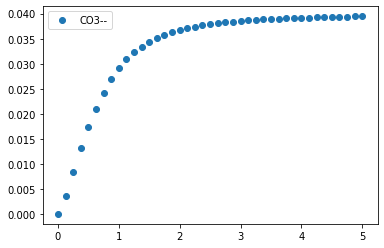

In [621]:
i = 1
plt.plot(builder.ygrid, np.exp(logc[i, :]), 'o', label=builder.species[i])
plt.legend()

In [509]:
eqsys.species

['H2O',
 'CO2',
 'CO3--',
 'Ca++',
 'CaCO3',
 'CaHCO3+',
 'CaOH+',
 'Cl-',
 'H+',
 'HCO3-',
 'Na+',
 'Na2CO3',
 'NaCO3-',
 'NaHCO3',
 'NaOH',
 'OH-']